## Tratamento e Preparação de Dados — Análise de Desempenho Logístico

Autor: João Victor Sacramento

Contexto e Problemática

  O desempenho logístico é um fator crítico para empresas de e-commerce, impactando diretamente a experiência do cliente, os custos operacionais e a competitividade do negócio. Atrasos recorrentes nas entregas podem gerar insatisfação, aumento de reclamações e perda de confiança na marca, especialmente quando ocorrem de forma desigual entre diferentes regiões do país.

  Além do cumprimento dos prazos de entrega, a percepção do cliente em relação ao serviço prestado — refletida por meio de avaliações — representa uma dimensão fundamental para a análise do desempenho logístico. Assim, compreender a relação entre atrasos, localização geográfica e satisfação do cliente torna-se essencial para apoiar decisões estratégicas baseadas em dados.

# Objetivo do Tratamento de Dados

  Este notebook corresponde à primeira etapa do projeto e tem como objetivo realizar o tratamento, a integração e a preparação dos dados brutos, transformando-os em bases analíticas estruturadas, consistentes e prontas para análises exploratórias e visualizações.

  Nesta etapa, são aplicadas técnicas de limpeza, padronização, transformação e agregação de dados, assegurando a qualidade, a confiabilidade e a integridade das informações que serão utilizadas nas etapas seguintes do projeto, tanto para análises exploratórias em Python quanto para a construção de dashboards no Looker Studio.

#Fonte dos Dados

  Os dados utilizados neste projeto foram obtidos a partir de um conjunto de dados público disponibilizado na plataforma Kaggle, intitulado Brazilian E-Commerce Public Dataset by Olist.

  O dataset contém dados reais anonimizados de um e-commerce brasileiro, incluindo informações sobre pedidos, clientes, entregas, avaliações e localização geográfica, sendo amplamente utilizado em projetos acadêmicos e de análise de dados.

Link da base de dados:
https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

#Descrição do Dataset

  Para o desenvolvimento desta etapa do projeto, foram utilizadas as seguintes tabelas do dataset Olist:

  Tabela de pedidos (orders): contém informações sobre o status do pedido, datas de compra, datas estimadas de entrega e datas reais de entrega.

  Tabela de clientes (customers): contém informações geográficas dos clientes, como estado de residência, permitindo a segmentação regional da análise.

  Tabela de avaliações (order_reviews): contém as notas atribuídas pelos clientes aos pedidos, representando um indicador direto de satisfação.

  Essas tabelas foram integradas por meio de chaves comuns, possibilitando a construção de uma base consolidada que associa cada pedido à sua respectiva localização geográfica e, quando disponível, à sua avaliação.

#Metodologia de Tratamento

O tratamento dos dados foi realizado utilizando PySpark, escolhido por sua eficiência no processamento de grandes volumes de dados e por refletir boas práticas de engenharia e análise de dados em ambientes analíticos escaláveis.

As principais etapas realizadas neste notebook incluem:


*   Leitura dos dados brutos
*   Padronização e tratamento de colunas de data e hora
*   Integração das tabelas de pedidos e clientes
*   Criação de variáveis derivadas relacionadas ao tempo de entrega
*   Cálculo da diferença entre datas estimadas e reais de entrega
*   Classificação dos pedidos em entregues no prazo ou com atraso
*   Tratamento da tabela de avaliações, incluindo:
    * seleção apenas das colunas relevantes (order_id e review_score)
    * remoção de registros nulos
    * tratamento de valores inconsistentes e textos inválidos
    * garantia de uma única avaliação por pedido
*   Integração da base de avaliações à base principal de pedidos
*   Criação de visões analíticas distintas:

    * uma base completa para análise operacional (incluindo pedidos sem avaliação)

    * uma base derivada para análise de satisfação (considerando apenas pedidos avaliados)
*   Agregação dos dados por região geográfica
*   Geração de arquivos finais em formato CSV para uso nas etapas seguintes do projeto

Ao final desse processo, são geradas bases de dados tratadas, limpas e estruturadas, que servirão como insumo para a análise exploratória com Pandas, a criação de visualizações com bibliotecas gráficas em Python e a construção de dashboards interativos no Looker Studio.

In [2]:
#imports
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
spark = SparkSession.builder.getOrCreate()

In [3]:
# Carregamento dos dados (CSV pt-BR)
clientes_df = spark.read.csv('drive/MyDrive/E-commerce/olist_customers_dataset.csv',header = True , inferSchema = True)
pedidos_df = spark.read.csv('drive/MyDrive/E-commerce/olist_orders_dataset.csv',header = True , inferSchema = True)
reviews_df = spark.read.csv('/content/drive/MyDrive/E-commerce/olist_order_reviews_dataset.csv',header = True , inferSchema = True)

In [4]:
# Visualização das tabelas
clientes_df.show(2)
pedidos_df.show(2)
reviews_df.show(2)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 2 rows
+--------------------+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+
|            order_id|         customer_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_

In [5]:
# Inspeção rápida
clientes_df.printSchema()
pedidos_df.printSchema()
reviews_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)

root
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: string (nullable = true)
 |-- review_comment_title: string (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_creation_date: string (nullable = true)
 |-- review_answer_timestamp: 

In [6]:
print('clientes com customer id nulos:',clientes_df.filter(col('customer_id').isNull()).count())
print('pedidos com order_id nulos:',pedidos_df.filter(col('order_id').isNull()).count())
print('pedidos com custumer_id nulos:',pedidos_df.filter(col('customer_id').isNull()).count())
print('review com order_id nulos: ',reviews_df.filter(col('order_id').isNull()).count())

clientes com customer id nulos: 0
pedidos com order_id nulos: 0
pedidos com custumer_id nulos: 0
review com order_id nulos:  2236


In [8]:
pedidos_filtrados_df = pedidos_df.filter(col('order_status') == 'delivered')

In [9]:
qtd_nulos_status = pedidos_filtrados_df.filter(col('order_status').isNull()).count()
qtd_nulos_delivered = pedidos_filtrados_df.filter(col('order_delivered_customer_date').isNull()).count()
qtd_nulos_estimated = pedidos_filtrados_df.filter(col('order_estimated_delivery_date').isNull()).count()
print('Quantidade de nulos por order_status: ',qtd_nulos_status)
print('Quantidade de nulos por order_delivered_customer_date: ',qtd_nulos_delivered)
print('Quantidade de nulos por order_estimated_delivery_date: ', qtd_nulos_estimated)

Quantidade de nulos por order_status:  0
Quantidade de nulos por order_delivered_customer_date:  8
Quantidade de nulos por order_estimated_delivery_date:  0


In [10]:
pedidos_filtrados_df = pedidos_filtrados_df.na.drop(subset=['order_delivered_customer_date'])

In [11]:
# Padronização de datas
pedidos_filtrados_df = pedidos_filtrados_df.withColumn('order_approved_at',to_date(col('order_approved_at')))
pedidos_filtrados_df = pedidos_filtrados_df.withColumn('order_delivered_customer_date',to_date(col('order_delivered_customer_date')))
pedidos_filtrados_df = pedidos_filtrados_df.withColumn('order_estimated_delivery_date',to_date(col('order_estimated_delivery_date')))

In [12]:
# A métrica principal utilizada na análise é a diferença entre a data real
# de entrega e a data estimada, pois representa a percepção do cliente
# sobre atraso ou adiantamento da entrega.

pedidos_filtrados_df = pedidos_filtrados_df.withColumn(
    'dias_diferenca_entrega',
    datediff(
        col('order_delivered_customer_date'),
        col('order_estimated_delivery_date')
    )
)

In [13]:
pedidos_filtrados_df = pedidos_filtrados_df.withColumn('delivery_status',when(col('dias_diferenca_entrega')>0,'Atrasado').when(col('dias_diferenca_entrega')< 0,'Adiantado').otherwise('No prazo'))

In [14]:
# verificação de duplicates
duplicates = clientes_df.groupBy('customer_id').count().filter(col('count') > 1).count()
print(duplicates)

0


In [15]:
##Enriquecimento geográfico: mapeamento de estado para região
clientes_df = clientes_df.withColumn('regiao', when(col('customer_state').isin(['SP','MG','RJ','ES']),'Sudeste').when(col('customer_state').isin(['RS','SC','PR']),'Sul').\
                                     when(col('customer_state').isin(['GO','DF','MT','MS']),'Centro-Oeste').when(col('customer_state').isin(['AM','AC','AP','PA','RO','RR','TO']),'Norte').\
                                     when(col('customer_state').isin(['BA','SE','AL','PE','PB','RN','CE','PI']),'Nordeste').otherwise('Outros'))

In [19]:
#Integração das tabelas (JOIN)
pedidos_clientes_df = pedidos_filtrados_df.join(clientes_df.select('customer_id','customer_state','regiao'),on = 'customer_id',how = 'left')
pedidos_clientes_df.show()

+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+----------------------+---------------+--------------+------------+
|         customer_id|            order_id|order_status|order_purchase_timestamp|order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|dias_diferenca_entrega|delivery_status|customer_state|      regiao|
+--------------------+--------------------+------------+------------------------+-----------------+----------------------------+-----------------------------+-----------------------------+----------------------+---------------+--------------+------------+
|9ef432eb625129730...|e481f51cbdc54678b...|   delivered|     2017-10-02 10:56:33|       2017-10-02|         2017-10-04 19:55:00|                   2017-10-10|                   2017-10-18|                    -8|      Adiantado|     

In [18]:
#remoção de colunas
pedidos_clientes_data = pedidos_clientes_df.drop('order_delivered_carrier_date','order_purchase_timestamp')
pedidos_clientes_data.show()

+--------------------+--------------------+------------+-----------------+-----------------------------+-----------------------------+----------------------+---------------+--------------+------------+
|         customer_id|            order_id|order_status|order_approved_at|order_delivered_customer_date|order_estimated_delivery_date|dias_diferenca_entrega|delivery_status|customer_state|      regiao|
+--------------------+--------------------+------------+-----------------+-----------------------------+-----------------------------+----------------------+---------------+--------------+------------+
|9ef432eb625129730...|e481f51cbdc54678b...|   delivered|       2017-10-02|                   2017-10-10|                   2017-10-18|                    -8|      Adiantado|            SP|     Sudeste|
|b0830fb4747a6c6d2...|53cdb2fc8bc7dce0b...|   delivered|       2018-07-26|                   2018-08-07|                   2018-08-13|                    -6|      Adiantado|            BA|    

In [23]:
reviews_df = reviews_df.na.drop(subset='order_id')
print('review com order_id nulos: ',reviews_df.filter(col('order_id').isNull()).count())
duplicados_reviews = reviews_df.groupBy('order_id').count().filter(col('count') > 1).count()
print('Números de order_id duplicados',duplicados_reviews)

review com order_id nulos:  0
Números de order_id duplicados 950


In [48]:
reviews_limpo = (
    reviews_df
    .select("order_id", "review_score")
    .filter(col("order_id").isNotNull())
    .withColumn("review_score_str", trim(col("review_score").cast("string")))
    # extrai 1 dígito 1..5; se não achar, retorna '' (string vazia)
    .withColumn("score_digit", regexp_extract(col("review_score_str"), r"([1-5])", 1))
    # só converte quando NÃO for vazio
    .withColumn(
        "review_score",
        when(col("score_digit") != "", col("score_digit").cast("int"))
    )
    .filter(col("review_score").isNotNull())
    .select("order_id", "review_score")
)


In [49]:
reviews_limpo.select("review_score").distinct().orderBy("review_score").show()

+------------+
|review_score|
+------------+
|           1|
|           2|
|           3|
|           4|
|           5|
+------------+



In [50]:
from pyspark.sql.window import Window

w = Window.partitionBy("order_id").orderBy(col("review_score").desc())

reviews_1por_pedido = (
    reviews_limpo
    .withColumn("rn", row_number().over(w))
    .filter(col("rn") == 1)
    .select("order_id", "review_score")
)

In [52]:
pedidos_reviews_clientes_df = pedidos_clientes_data.join(reviews_1por_pedido,on = 'order_id',how = 'left')


In [59]:
#Volume geral
print('volume: ',pedidos_reviews_clientes_df.count())
#Distribuição de atrasos
print('Distribuição de atrasos ')
pedidos_reviews_clientes_df.select(
    count("*").alias("total_pedidos"),
    count(when(col("dias_diferenca_entrega") > 0, True)).alias("atrasados"),
    count(when(col("dias_diferenca_entrega") <= 0, True)).alias("no_prazo")
).show()
print()
print('Atraso médio por região')
pedidos_reviews_clientes_df.groupBy("regiao") \
    .agg(avg("dias_diferenca_entrega").alias("atraso_medio")) \
    .orderBy("atraso_medio", ascending=False) \
    .show()
print('Nota média por status de entrega')
pedidos_reviews_clientes_df.filter(col("review_score").isNotNull()) \
    .groupBy("delivery_status") \
    .agg(avg("review_score").alias("nota_media")) \
    .show()

volume:  96470
Distribuição de atrasos 
+-------------+---------+--------+
|total_pedidos|atrasados|no_prazo|
+-------------+---------+--------+
|        96470|     6534|   89936|
+-------------+---------+--------+


Atraso médio por região
+------------+-------------------+
|      regiao|       atraso_medio|
+------------+-------------------+
|      Outros| -9.571827057182706|
|    Nordeste| -11.48853128377567|
|     Sudeste|-11.557793120118442|
|Centro-Oeste|-12.336593172119487|
|         Sul|-13.079997104177224|
|       Norte|-15.611915367483297|
+------------+-------------------+

Nota média por status de entrega
+---------------+-----------------+
|delivery_status|       nota_media|
+---------------+-----------------+
|      Adiantado|4.296167326429455|
|       Atrasado|2.273938254192133|
|       No prazo|       4.04140625|
+---------------+-----------------+



Análise Exploratória: Desempenho Logístico e Satisfação do Cliente


In [60]:
atraso_regiao_spark = pedidos_reviews_clientes_df.groupBy("regiao") \
    .agg(avg("dias_diferenca_entrega").alias("atraso_medio"))
pct_atraso_regiao= pedidos_reviews_clientes_df.groupBy("regiao").agg(
    (count(when(col("dias_diferenca_entrega") > 0, True)) / count("*")).alias("pct_atraso")
)
atraso_nota = pedidos_reviews_clientes_df.filter(col("review_score").isNotNull()) \
    .groupBy("delivery_status") \
    .agg(avg("review_score").alias("nota_media"))

atraso_regiao_pd = atraso_regiao_spark.toPandas()
pct_atraso_pd = pct_atraso_regiao.toPandas()
atraso_nota_pd = atraso_nota.toPandas()

In [66]:
corr_df_spark = pedidos_reviews_clientes_df \
    .filter(col("review_score").isNotNull())
corr_df = corr_df_spark.select(
    "dias_diferenca_entrega",
    "review_score"
).toPandas()

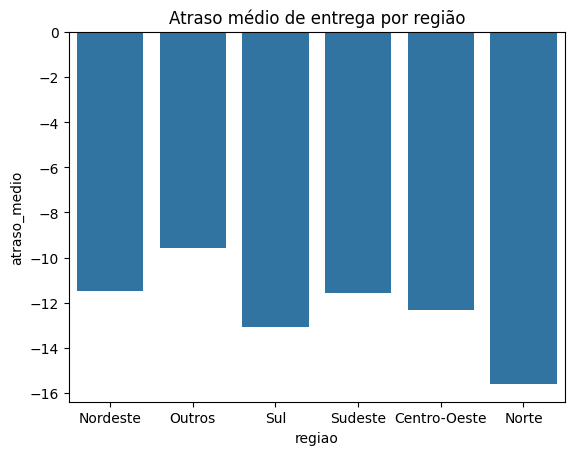

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(
    data=atraso_regiao_pd,
    x="regiao",
    y="atraso_medio"
)
plt.title("Atraso médio de entrega por região")
plt.show()

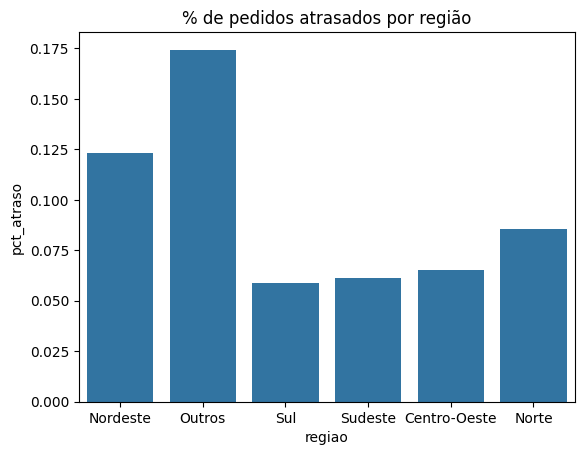

In [63]:
sns.barplot(
    data=pct_atraso_pd,
    x="regiao",
    y="pct_atraso"
)
plt.title("% de pedidos atrasados por região")
plt.show()

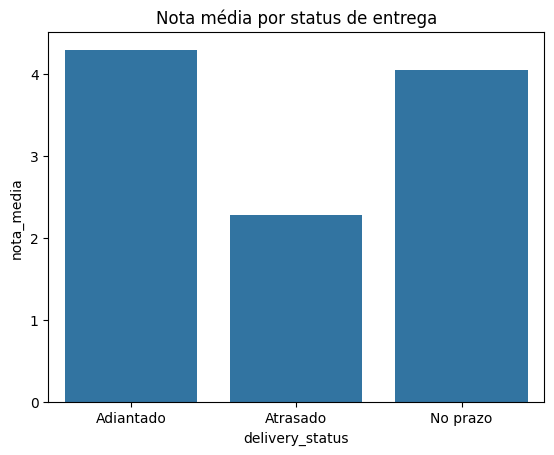

In [65]:
sns.barplot(
    data=atraso_nota_pd,
    x="delivery_status",
    y="nota_media"
)
plt.title("Nota média por status de entrega")
plt.show()

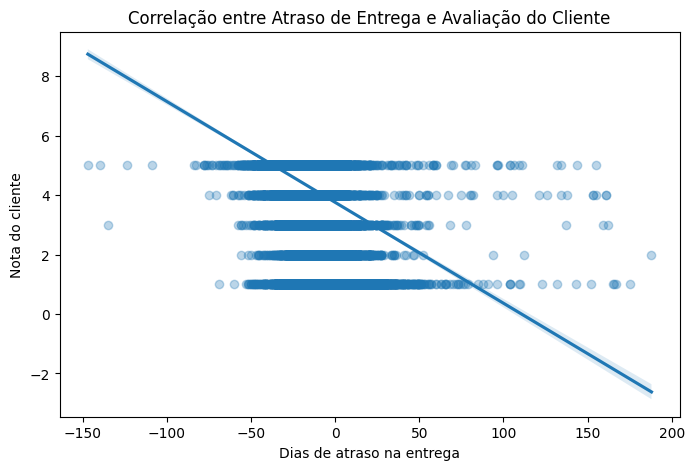

In [67]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=corr_df,
    x="dias_diferenca_entrega",
    y="review_score",
    scatter_kws={"alpha": 0.3}
)

plt.title("Correlação entre Atraso de Entrega e Avaliação do Cliente")
plt.xlabel("Dias de atraso na entrega")
plt.ylabel("Nota do cliente")
plt.show()

In [68]:
#Exportação dos dados tratados
pedidos_reviews_clientes_df.coalesce(1).write.mode('overwrite').option('header',True).csv('drive/MyDrive/E-commerce/pedidos_reviews_clientes_df.csv')
